In [1]:
from pathlib import Path
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
path_grand_dad = Path("./runs")
paths_dad = [x for x in path_grand_dad.iterdir() if x.is_dir()]
finished_paths = []
mapping_run = {}
for path_dad in paths_dad:
    if path_dad.stem != "Transformer": #here I mistakenly had 2 heads in the transformer
        paths_now = [x for x in  [z for z in path_dad.iterdir() if z.is_dir()] if "averages" in [y.stem for y in x.iterdir()]]
        finished_paths.extend(paths_now)
        for path_now in paths_now:
            mapping_run[path_now.stem] = path_dad.stem

In [3]:
dfs = []
dfs_stds = []
dfs_lists = []
configurations = {}
for path in finished_paths:
    with open(path / "averages.json", "r") as f:
        averages = json.load(f)
    
    df = pd.Series(averages)
    dfs.append(df)

    with open(path / "results.json", "r") as f:
        results = json.load(f)

    stds = {k: np.std(v, ddof=1) for k, v in results.items()}
    df_std = pd.Series(stds)
    dfs_stds.append(df_std)

    df_list = pd.Series(results)
    dfs_lists.append(df_list)

    with open(path / "config.json", "r") as f:
        config = json.load(f)

    configurations[path.stem] = config
    

    
df = pd.concat(dfs, axis=1)
df.columns = [x.stem for x in finished_paths]
df = df.T
#map the experiment name to the df
df["experiment"] = df.index.map(lambda x: mapping_run[x]) 


df_std = pd.concat(dfs_stds, axis=1)
df_std.columns = [x.stem for x in finished_paths]
df_std = df_std.T
df_std["experiment"] = df_std.index.map(lambda x: mapping_run[x])

df_list = pd.concat(dfs_lists, axis=1)
df_list.columns = [x.stem for x in finished_paths]
df_list = df_list.T
df_list["experiment"] = df_list.index.map(lambda x: mapping_run[x])


df.sort_values(by="val_auprc_custom", ascending=False, inplace=True)

In [4]:
mapping_column_names_metrics = {
    "epoch": "Number of Epochs",
    "val_auprc_custom": "Weighted AUPRC",
    "val_auprc": "Macro AUPRC",
    "val_precision": "Macro Precision",
    "val_recall": "Macro Recall",
    "val_f1": "Macro F1",
    "val_auroc": "Macro AUROC",
    "val_accuracy": "Accuracy",
    "val_loss": "Validation Loss",
}
mapping_column_names_metrics_std = {
    "epoch": "Std Number of Epochs",
    "val_auprc_custom": "Std Weighted AUPRC",
    "val_auprc": "Std Macro AUPRC",
    "val_precision": "Std Macro Precision",
    "val_recall": "Std Macro Recall",
    "val_f1": "Std Macro F1",
    "val_auroc": "Std Macro AUROC",
    "val_accuracy": "Std Accuracy",
    "val_loss": "Std Validation Loss",
}
mapping_global_search_space_names = {
        "batch_size": "Batch Size",
        "base_seed": "Base Seed",
        "learning_rate": "Learning Rate",
        "weight_decay": "Weight Decay",
        "optimizer":  "Optimizer",
        "scheduler": "Scheduler",
        "criterion": "Criterion",
        "seq_len": "Sequence Length",
        "kmer": "K-mer Size",
        "embed": "Embedding Type",
    }

mapping_model_search_spaces = {
    "RNN": {
        "embed_dim":   "RNN Embedding Dimension",
        "hidden_dim":  "RNN Hidden Dimension",
        "num_layers":   "RNN Number of Layers",
        "rnn_type":     "RNN Type",
        "bidirectional": "RNN Bidirectional",
        "dropout":     "RNN Dropout Rate",
        "pooling":      "RNN Pooling Type",
    },
    "1DCNN": {              
        "num_filters": "1DCNN Filters",
        "kernel_sizes": "1DCNN Kernels",
        "pool_sizes": "1DCNN Max Pooling",
        "drop_out_rate": "1DCNN Dropout Rate",
    },
    "Transformer": {
        "embed_dim": "Transformer Embedding Dimension",
        "num_blocks": "Transformer Number of Blocks",
        "num_heads": "Transformer Number of Heads",
        "head_type":  "Transformer Pooling Type",
    }
}


In [5]:
df.rename(columns=mapping_column_names_metrics, inplace=True)
df.drop(columns=["experiment"], inplace=True)
df_std.rename(columns=mapping_column_names_metrics_std, inplace=True)
df_std.drop(columns=["experiment"], inplace=True)

#merge the two dataframes (the index is the order of df)
df_full = pd.concat([df, df_std], axis=1)

order = [val for pair in zip(mapping_column_names_metrics.values(),mapping_column_names_metrics_std.values()) for val in pair]
df_full = df_full[order]

def converge_check(row):
    epochs = row["epoch"]
    if len([x for x in epochs if x < 140]) < 5:
        return "No"
    return "Yes"

converge_mapping = df_list.apply(converge_check, axis=1)
df_full["Converged"] = converge_mapping
df_full["Model"] = df_full.index.map(lambda x: configurations[x]["model"])

In [ ]:
global_params = {k: {mapping_global_search_space_names[key]: value for key, value in v['global_params'].items() 
                     if mapping_global_search_space_names.get(key) is not None} for k, v in configurations.items()}
df_full = df_full.join(pd.DataFrame(global_params).T)

scheduler_patience_mapping ={"RNN": 4, "1DCNN": 6, "Transformer": 6}
for model, patience in scheduler_patience_mapping.items():
    df_full.loc[df_full["Model"] == model, "Scheduler Patience"] = patience

for model in ["RNN", "Transformer", "1DCNN"]:
    configurations_model = {k: v["model_params"] for k, v in configurations.items() if v["model"] == model}
    configurations_model ={k: {mapping_model_search_spaces[model][key]: value for key, value in v.items() if 
                               mapping_model_search_spaces[model].get(key) is not None} for k, v in configurations_model.items()}
    configurations_model = pd.DataFrame(configurations_model).T
    df_full = df_full.join(configurations_model)
    df_full.fillna("/", inplace=True)
change_names = {"avg": "Average", 
                "central": "Central Vector",
                "central_attention": "Central Weighting",
                "attention": "Weighted",
                "max": "Max",
                "average_attention": "Attention",
                }
for key, value in change_names.items():
    df_full.replace(key, value, inplace=True)

df_full["1DCNN Layers"] = df_full["1DCNN Filters"].apply(lambda x : len(x) if isinstance(x, list) else "/")

df_full["Weight Decay"] = df_full["Weight Decay"].apply(lambda x: f"{x:.0e}" if isinstance(x, float) else x)
df_full["Learning Rate"] = df_full["Learning Rate"].apply(lambda x: f"{x:.0e}" if isinstance(x, float) else x)
df_full["Embedding Type"] = df_full["Embedding Type"].apply(lambda x: "One-Hot" if x == "one_hot" else x)
df_full["Criterion"] = df_full["Criterion"].apply(lambda x: "Cross Entropy" if x == "CrossEntropyLoss" else x)
df_full["RNN Bidirectional"] = df_full["RNN Bidirectional"].apply(lambda x: "Yes" if x else "No")
df_full.to_csv("./results/results_grid_search/results_full.csv", index=True)


/tmp/ipykernel_3622659/3402334960.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_full.replace(key, value, inplace=True)


In [ ]:
mapping_run_filtered = {k: v for k, v in mapping_run.items() if (v != "RNN_central_a_little_bigger") 
                        and (v != "RNN_central_weight_decay_check") and (v != "Transformer_101")}

mapping_run_filtered_transformer = {k: v for k, v in mapping_run.items() if not v.startswith("RNN") 
                        and not v.startswith("RNN")}

df_fuLl_filtered = df_full.loc[mapping_run_filtered.keys()].copy()
df_fuLl_filtered.sort_values(by="Weighted AUPRC", ascending=False, inplace=True)
#to excel
df_fuLl_filtered.to_excel("./results/results_grid_search/results_grid_search.xlsx", index=True)

df_fuLl_filtered_transformer = df_full.loc[mapping_run_filtered_transformer.keys()].copy()
df_fuLl_filtered_transformer.sort_values(by="Weighted AUPRC", ascending=False, inplace=True)

In [8]:
#remove columns: Scheduler, Scheduler Patience, Base Seed, Criterion
df_fuLl_filtered.drop(columns=["Scheduler", "Scheduler Patience", "Base Seed", "Criterion", "Converged", "Validation Loss"], inplace=True)

df_fuLl_filtered_transformer.drop(columns=["Scheduler", "Scheduler Patience", "Base Seed", "Criterion", "Converged"], inplace=True)

In [13]:
top_10_transformer = df_fuLl_filtered[(df_fuLl_filtered["Model"] == "Transformer") & (df_fuLl_filtered["Sequence Length"] == 51)].nlargest(10, "Weighted AUPRC").drop(columns=[x for x in df_fuLl_filtered.columns if "RNN" in x or "1DCNN" in x]).reset_index(drop=True)
top_10_1dcnn = df_fuLl_filtered[df_fuLl_filtered["Model"] == "1DCNN"].nlargest(10, "Weighted AUPRC").drop(columns=[x for x in df_fuLl_filtered.columns if "RNN" in x or "Transformer" in x]).reset_index(drop=True)
top_10_rnn = df_fuLl_filtered[df_fuLl_filtered["Model"] == "RNN"].nlargest(10, "Weighted AUPRC").drop(columns=[x for x in df_fuLl_filtered.columns if "1DCNN" in x or "Transformer" in x]).reset_index(drop=True)

top_10_difflength_transformer = df_fuLl_filtered_transformer[df_fuLl_filtered_transformer["Model"] == "Transformer"].nlargest(10, "Weighted AUPRC").drop(columns=[x for x in df_fuLl_filtered_transformer.columns if "RNN" in x or "1DCNN" in x]).reset_index(drop=True)

top_10_transformer.index = top_10_transformer.index + 1
top_10_1dcnn.index = top_10_1dcnn.index + 1
top_10_rnn.index = top_10_rnn.index + 1
top_10_difflength_transformer.index = top_10_difflength_transformer.index + 1

In [14]:
def truncate_and_std(dataframe):
    metrics = list(mapping_column_names_metrics.values())
    for m in metrics:
        std_col = f"Std {m}"
        if m in dataframe.columns and std_col in dataframe.columns:
            if "Epochs" in m:
                dataframe[m] = dataframe.apply(
                    lambda row: f"$ {row[m]:.1f}{{\\scriptstyle \\pm{row[std_col]:.1f}}}$",
                    axis=1
                )
            else:
                dataframe[m] = dataframe.apply(
                    lambda row: f"$ {row[m]:.3f}{{\\scriptstyle \\pm{row[std_col]:.3f}}}$",
                    axis=1
                )

    std_cols = [f"Std {m}" for m in metrics if f"Std {m}" in dataframe.columns]
    dataframe.drop(columns=std_cols, inplace=True)

    return dataframe


top_10_transformer = truncate_and_std(top_10_transformer)
top_10_1dcnn = truncate_and_std(top_10_1dcnn)
top_10_rnn = truncate_and_std(top_10_rnn)
top_10_difflength_transformer = truncate_and_std(top_10_difflength_transformer)

In [ ]:
#get only the first 10 columns of each (split in two)
top_10_transformer_metrics = top_10_transformer.iloc[:, :8]
top_10_difflength_transformer_metrics = top_10_difflength_transformer.iloc[:, :8]
top_10_1dcnn_metrics = top_10_1dcnn.iloc[:, :8]
top_10_rnn_metrics = top_10_rnn.iloc[:, :8]
top_10_transformer_params = top_10_transformer.iloc[:, 8:]
top_10_transformer_params.columns = [col.replace("Transformer ", "") for col in top_10_transformer_params.columns]
top_10_difflength_transformer_params = top_10_difflength_transformer.iloc[:, 8:]
top_10_difflength_transformer_params.columns = [col.replace("Transformer ", "") for col in top_10_difflength_transformer_params.columns]
top_10_1dcnn_params = top_10_1dcnn.iloc[:, 8:]
top_10_1dcnn_params.columns = [col.replace("1DCNN ", "") for col in top_10_1dcnn_params.columns]
top_10_rnn_params = top_10_rnn.iloc[:, 8:]
top_10_rnn_params.columns = [col.replace("RNN ", "") for col in top_10_rnn_params.columns]
top_10_rnn_params.drop(columns=["Type", "Bidirectional"], inplace=True)  # RNN Number of Layers is not a parameter in the grid search

top_3_overall_metrics = pd.concat([pd.DataFrame(top_10_rnn_metrics.iloc[0]).T, 
           pd.DataFrame(top_10_transformer_metrics.iloc[0]).T, 
           pd.DataFrame(top_10_1dcnn_metrics.iloc[0]).T], 
          axis=0).drop(columns=("Number of Epochs"))
top_3_overall_metrics.index = ["RNN", "Transformer", "1DCNN"]


top_10_difflength_transformer_metrics["Sequence Length"] = top_10_difflength_transformer_params["Sequence Length"]
#set first column to sequence length
top_10_difflength_transformer_metrics = top_10_difflength_transformer_metrics[["Sequence Length"] + [col for col in top_10_difflength_transformer_metrics.columns if col != "Sequence Length"]]

In [16]:
latex_transformer_metrics = top_10_transformer_metrics.to_latex(escape=False)
latex_1dcnn_metrics = top_10_1dcnn_metrics.to_latex(escape=False)
latex_rnn_metrics = top_10_rnn_metrics.to_latex(escape=False)
latex_transformer_params = top_10_transformer_params.to_latex(escape=False)
latex_1dcnn_params = top_10_1dcnn_params.to_latex(escape=False)
latex_rnn_params = top_10_rnn_params.to_latex(escape=False)

latex_top3_overall_metrics = top_3_overall_metrics.to_latex(escape=False)

latex_difflength_transformer_metrics = top_10_difflength_transformer_metrics.to_latex(escape=False)

In [22]:
print(latex_transformer_metrics)

\begin{tabular}{lllllllll}
\toprule
 & Number of Epochs & Weighted AUPRC & Macro AUPRC & Macro Precision & Macro Recall & Macro F1 & Macro AUROC & Accuracy \\
\midrule
1 & $ 22.6{\scriptstyle \pm11.1}$ & $ 0.973{\scriptstyle \pm0.002}$ & $ 0.968{\scriptstyle \pm0.002}$ & $ 0.889{\scriptstyle \pm0.022}$ & $ 0.951{\scriptstyle \pm0.004}$ & $ 0.917{\scriptstyle \pm0.012}$ & $ 0.991{\scriptstyle \pm0.001}$ & $ 0.936{\scriptstyle \pm0.003}$ \\
2 & $ 26.2{\scriptstyle \pm10.5}$ & $ 0.973{\scriptstyle \pm0.002}$ & $ 0.967{\scriptstyle \pm0.003}$ & $ 0.899{\scriptstyle \pm0.010}$ & $ 0.948{\scriptstyle \pm0.008}$ & $ 0.922{\scriptstyle \pm0.006}$ & $ 0.992{\scriptstyle \pm0.001}$ & $ 0.936{\scriptstyle \pm0.005}$ \\
3 & $ 23.6{\scriptstyle \pm5.9}$ & $ 0.973{\scriptstyle \pm0.001}$ & $ 0.967{\scriptstyle \pm0.001}$ & $ 0.878{\scriptstyle \pm0.010}$ & $ 0.954{\scriptstyle \pm0.003}$ & $ 0.912{\scriptstyle \pm0.007}$ & $ 0.992{\scriptstyle \pm0.001}$ & $ 0.936{\scriptstyle \pm0.004}$ \\
4 & $ 16

### After training the best models on grid search, we record their performance on the test set

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pickle, json
from pathlib import Path
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from utils.training_metrics import test_metrics

from utils.search_space import model_mapping
from utils.seed         import set_global_seed



In [ ]:
mapping_models = {
    "Transformer": {"path_conf":Path("./runs/Transformer_average_attention/run_11_30_05_2025_15_41_04/config.json"),
                    "path_weights": Path("./logs/Transformer/Transformer_epoch_23.pt")},
    "RNN": {"path_conf":Path("./runs/RNN_central_attention/run_32_19_05_2025_23_41_30/config.json"),
            "path_weights": Path("./logs/RNN/RNN_epoch_43.pt")},
    "1DCNN": {"path_conf":Path("./runs/1DCNN/run_11_24_05_2025_16_51_52/config.json"),
                    "path_weights": Path("./logs/1DCNN/1DCNN_epoch_50.pt")},
}

def test_res(path_config, path_weights):
    with open(path_config, 'r') as f:
        config = json.load(f)

    model_name = config["model"]
    model_params = config["model_params"]

    seq_len = model_params["seq_len"]
    embed = model_params["embed"]
    kmer = model_params["kmer"]

    batch_size = 256
    seed = 42
    set_global_seed(seed)

    dataset_path = Path(os.getcwd()).parent / "dataset/test_set.pickle"
    with open(dataset_path, 'rb') as f:
        data = pickle.load(f)


    from dataset_generation.val_dataset import Datasetval as Dataset_

    dataset_ = Dataset_(
        data_dict=data,
        base_seed=seed,
        embed=embed,
        kmer=kmer,
        seq_len=seq_len,
    )

    dataloader = DataLoader(dataset_, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)



    model = model_mapping(model_name)(**model_params)
    model.load_state_dict(torch.load(path_weights, map_location=torch.device('cpu')))
    model.eval()
    if torch.cuda.is_available():
        model = model.cuda()

    results, cmx = test_metrics(model, dataloader)
    return results, cmx

results_all = {}
cmx_all = {}
for model, paths in mapping_models.items():
    path_config = paths["path_conf"]
    path_weights = paths["path_weights"]

    results, cmx = test_res(path_config, path_weights)

    print(f"Results for {model}:")
    print(results)
    print("Confusion Matrix:")
    print(cmx)
    print("\n" + "="*50 + "\n")
    results_all[model] = results
    cmx_all[model] = cmx

Results for Transformer:
{'test_f1': 0.9259086140908594, 'test_precision': 0.9003846107643996, 'test_recall': 0.9561733158367897, 'test_auprc': 0.9703996367809304, 'test_auprc_custom': 0.9756161668517117, 'test_auroc': 0.9921033629406454, 'test_accuracy': 0.9405727318803851}
Confusion Matrix:
      0     1     2   3    4
0  3623   243    37  13   30
1   113  2145     0   2   16
2     5     0  1376   0    0
3     5     0     0  96    0
4     5     0     0   0  183


Results for RNN:
{'test_f1': 0.9300741894820372, 'test_precision': 0.9081558255056714, 'test_recall': 0.9550264828327129, 'test_auprc': 0.9725591033555581, 'test_auprc_custom': 0.9774630426017565, 'test_auroc': 0.993070435558213, 'test_accuracy': 0.9433603649265079}
Confusion Matrix:
      0     1     2   3    4
0  3658   213    35  13   27
1   134  2131     0   3    8
2     3     0  1378   0    0
3     6     0     0  95    0
4     5     0     0   0  183


Results for 1DCNN:
{'test_f1': 0.9147777900273761, 'test_precision': 

In [28]:
mapping_column_names_metrics = {
    "test_auprc_custom": "Weighted AUPRC",
    "test_auprc": "Macro AUPRC",
    "test_precision": "Macro Precision",
    "test_recall": "Macro Recall",
    "test_f1": "Macro F1",
    "test_auroc": "Macro AUROC",
    "test_accuracy": "Accuracy",
}


res_test = pd.DataFrame(results_all).T
res_test.rename(columns=mapping_column_names_metrics, inplace=True)
#reorder the columns
res_test = res_test[list(mapping_column_names_metrics.values())]
res_test.sort_values(by="Weighted AUPRC", ascending=False, inplace=True)
res_test = res_test.map(lambda x: f"${x:.3f}$")
print(res_test.to_latex(escape=False))

\begin{tabular}{llllllll}
\toprule
 & Weighted AUPRC & Macro AUPRC & Macro Precision & Macro Recall & Macro F1 & Macro AUROC & Accuracy \\
\midrule
RNN & $0.977$ & $0.973$ & $0.908$ & $0.955$ & $0.930$ & $0.993$ & $0.943$ \\
Transformer & $0.976$ & $0.970$ & $0.900$ & $0.956$ & $0.926$ & $0.992$ & $0.941$ \\
1DCNN & $0.974$ & $0.968$ & $0.879$ & $0.961$ & $0.915$ & $0.992$ & $0.940$ \\
\bottomrule
\end{tabular}



### For the barplot in the article

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


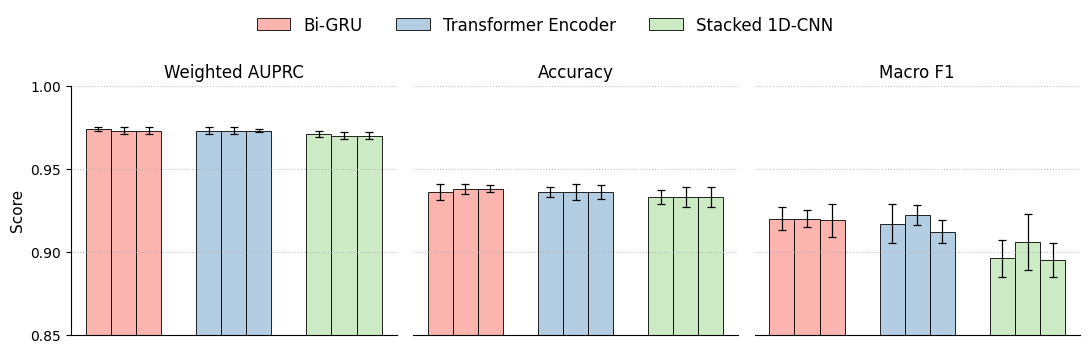

In [13]:
import matplotlib.pyplot as plt
import numpy as np

full_dict = {
    "Weighted AUPRC": {
        "values": [[0.974, 0.973, 0.973], [0.973, 0.973, 0.973], [0.971, 0.970, 0.970]],
        "stds":   [[0.001, 0.002, 0.002], [0.002, 0.002, 0.001], [0.002, 0.002, 0.002]]
    },
    "Macro F1": {
        "values": [[0.920, 0.920, 0.919], [0.917, 0.922, 0.912], [0.896, 0.906, 0.895]],
        "stds":   [[0.007, 0.005, 0.010], [0.012, 0.006, 0.007], [0.011, 0.017, 0.010]]
    },
    "Accuracy": {
        "values": [[0.936, 0.938, 0.938], [0.936, 0.936, 0.936], [0.933, 0.933, 0.933]],
        "stds":   [[0.005, 0.003, 0.002], [0.003, 0.005, 0.004], [0.004, 0.006, 0.006]]
    }
}
labels = ['Bi-GRU', 'Transformer Encoder', 'Stacked 1D-CNN']
metrics = ["Weighted AUPRC", "Accuracy", "Macro F1"]

# Figure: shared y, tighter spacing
fig, axes = plt.subplots(1, 3, figsize=(11, 3.4), sharey=True)

cmap = plt.get_cmap('Pastel1')
model_colors = [cmap(i) for i in range(3)]

n_models = len(labels)
n_runs = 3
bar_width = 0.18
inner_gap = 0.0      # no gap within model
model_gap = 0.25     # small gap between models
group_width = n_runs * bar_width + inner_gap * (n_runs - 1)
centers = np.arange(n_models) * (group_width + model_gap)

for ax, metric in zip(axes, metrics):
    vals = np.array(full_dict[metric]["values"])  # (models, runs)
    stds = np.array(full_dict[metric]["stds"])

    # Draw bars: color by model, replicate color across runs
    for m in range(n_models):
        for j in range(n_runs):
            x = centers[m] + j * (bar_width + inner_gap)
            y = vals[m, j]
            yerr = stds[m, j]
            ax.bar(
                x, y, width=bar_width, color=model_colors[m], edgecolor='k', linewidth=0.6,
                yerr=yerr, capsize=3, error_kw={'elinewidth': 0.9, 'capthick': 0.9}
            )

    # Remove x-axis labels for all subplots
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    ax.set_ylim(0.85, 1.00)
    ax.set_yticks([0.85, 0.90, 0.95, 1.00])
    ax.grid(axis='y', linestyle=':', alpha=0.8)
    ax.set_title(metric, fontsize=12, pad=6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Y axis only on first subplot
axes[0].set_ylabel('Score', fontsize=11)

# Remove y-axis ticks and labels for 2nd and 3rd subplots
for ax in axes[1:]:
    ax.tick_params(left=False, labelleft=False)
    ax.spines['left'].set_visible(False)

# Custom legend with correct colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=model_colors[i], edgecolor='k', linewidth=0.6, label=labels[i]) 
                   for i in range(len(labels))]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, frameon=False, 
           bbox_to_anchor=(0.5, 1.05), fontsize=12)

fig.tight_layout()
fig.subplots_adjust(top=0.80, wspace=0.05)

# Save
plt.savefig("results/results_grid_search/grid_search_bars.pdf", bbox_inches="tight")
plt.savefig("results/results_grid_search/grid_search_bars.eps", bbox_inches="tight")